In [1]:
# Importing libraries
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from six import StringIO
from IPython.display import Image
from sklearn.svm import LinearSVC
from numpy.ma.core import sqrt
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    confusion_matrix
)

In [56]:
# Dataset
dFrame= pd.read_csv('studentGrade.csv')
dFrame.shape

(790, 33)

In [3]:
# DataPreprocessing
temp= dFrame.copy()
temp.drop(['school', 'address', 'famsize', 'Mjob', 'Fjob', 'reason', 'guardian'],axis=1 , inplace=True)
categorical = ['sex' , 'Pstatus' , 'schoolsup' , 'famsup', 'paid' , 'activities' , 'nursery' , 'higher' , 'internet' , 'romantic']
le = LabelEncoder()
temp[categorical] = temp[categorical].apply(lambda col: le.fit_transform(col))
temp.shape

(790, 26)

In [57]:
# Visualization
# sns.boxplot(y=temp['G3'])
# sns.pairplot(temp,kind='scatter',hue='G3')


In [4]:
from sklearn.model_selection import train_test_split

df2 = temp[['G1', 'G2', 'G3', 'absences', 'failures']]

X = df2.drop('G3', axis=1)
y = df2['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state= 42)
X_train.shape, X_test.shape

((711, 4), (79, 4))

In [5]:
model1 = DecisionTreeClassifier()
model2 = RandomForestClassifier()

models = [model1, model2,  ]
model_list = [ 'DecisionTreeClassifier','RandomForestClassifier']

# Results
results = pd.DataFrame(columns=["Test Accuracy", "Train Accuracy"], index=model_list)

# training the model

for i, model in enumerate(models):
    start = time.time()
    
    model.fit(X_train, y_train)

    # Predictions on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)


    models = model_list[i]
    results.loc[models, :] = [accuracy, accuracy_train ]
    end = time.time()

    print(models)
    print("MSE: ", mean_squared_error(y_test, y_test_pred))
    print("Train Acc: ", accuracy_train)
    print("Test Acc: ", accuracy)
    print("Time: ", end - start)



DecisionTreeClassifier
MSE:  2.9873417721518987
Train Acc:  0.8973277074542897
Test Acc:  0.7088607594936709
Time:  0.05556750297546387
RandomForestClassifier
MSE:  2.9873417721518987
Train Acc:  0.8973277074542897
Test Acc:  0.7088607594936709
Time:  0.23041677474975586


In [ ]:
# Improved random forest


In [32]:
import numpy as np

class ImprovedClassifier:
    def __init__(self, n_estimators=100, max_features=None, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.estimators = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.estimators = []

        for _ in range(self.n_estimators):
            # Randomly select features
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = min(self.max_features, n_features)

            random_features = np.random.choice(n_features, max_features, replace=False)

            random_samples = np.random.choice(n_samples, n_samples, replace=True)

            # Subsample the dataset
            X_subset = X[random_samples][:, random_features]
            y_subset = y[random_samples]

            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_subset, y_subset)
            self.estimators.append((tree, random_features))

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.estimators)), dtype=int)
        
        for i, (tree, features) in enumerate(self.estimators):
            X_subset = X[:, features]
            predictions[:, i] = tree.predict(X_subset)
        
        return np.mean(predictions, axis=1).round().astype(int)


class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stop criteria
        if depth == self.max_depth or n_samples < self.min_samples_split or n_labels == 1:
            return np.bincount(y).argmax()

        # Find the best split
        best_gini = np.inf
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = ~left_indices

                gini = self._gini_impurity(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        # Split the data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _gini_impurity(self, left_labels, right_labels):
        p_left = len(left_labels) / (len(left_labels) + len(right_labels))
        p_right = 1 - p_left

        gini_left = 1 - sum((np.bincount(left_labels) / len(left_labels)) ** 2)
        gini_right = 1 - sum((np.bincount(right_labels) / len(right_labels)) ** 2)

        return p_left * gini_left + p_right * gini_right

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, tree):
        if isinstance(tree, int):
            return tree

        feature, threshold, left_tree, right_tree = tree

        if x[feature] < threshold:
            return self._predict_tree(x, left_tree)
        else:
            return self._predict_tree(x, right_tree)


In [7]:
start = time.time()

clf = ImprovedClassifier(n_estimators=100, max_depth=None, min_samples_split=2)
clf.fit(X_train, y_train)

end = time.time()
# Predictions on the test set
predictions = clf.predict(X_test)
# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

train_predictions = clf.predict(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Time:", end-start)



Accuracy: 0.7658227848101266
Training Accuracy: 0.8939873417721519
Time: 0.14817380905151367


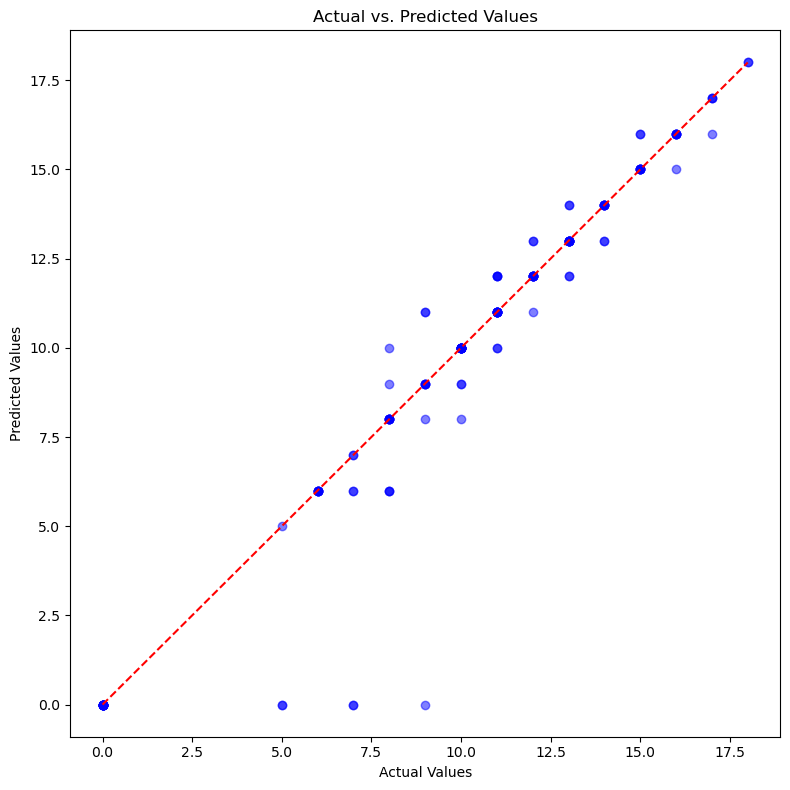

In [10]:
# Scatter plot
fig, axes = plt.subplots(figsize=(8, 8))
axes.scatter(y_test, predictions, color='blue', alpha=0.5)
axes.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
axes.set_title('Actual vs. Predicted Values')
axes.set_xlabel('Actual Values')
axes.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


In [ ]:
# ExtraTreesClassifier
start = time.time()

model = ExtraTreesClassifier(n_estimators=1000,  criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                       bootstrap=True, oob_score=False, n_jobs=-1, random_state=42, verbose=0, 
                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
model.fit(X_train, y_train)

# Predictions on the test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
end = time.time()

print("Training Accuracy: ", accuracy_train)
print("Testing Accuracy: ", accuracy)
print("Time Taken: ", end-start)